In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
from pyspark.sql import SQLContext
import boto3
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import bigrams
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sk_model import ReviewClassifier, main
import util

In [3]:
f_path = "s3://chizzy/yelp_data/"
df_bus = pd.read_json(f_path+"business.json", lines=True)
df_user = pd.read_json(f_path+"user.json", lines=True)
df_rev = pd.read_json(f_path+"review.json", lines=True)

In [4]:
df_bus.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9","{'AcceptsInsurance': True, 'ByAppointmentOnly'...",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,"{'Friday': '7:30-17:00', 'Tuesday': '7:30-17:0...",1,33.330690,-111.978599,Dental by Design,,85044,22,4.0,AZ
1,3101 Washington Rd,"{'BusinessParking': {'garage': False, 'street'...",He-G7vWjzVUysIKrfNbPUQ,"[Hair Stylists, Hair Salons, Men's Hair Salons...",McMurray,"{'Monday': '9:00-20:00', 'Tuesday': '9:00-20:0...",1,40.291685,-80.104900,Stephen Szabo Salon,,15317,11,3.0,PA
2,"6025 N 27th Ave, Ste 1",{},KQPW8lFf1y5BT2MxiSZ3QA,"[Departments of Motor Vehicles, Public Service...",Phoenix,{},1,33.524903,-112.115310,Western Motor Vehicle,,85017,18,1.5,AZ
3,"5000 Arizona Mills Cr, Ste 435","{'BusinessAcceptsCreditCards': True, 'Restaura...",8DShNS-LuFqpEWIp0HxijA,"[Sporting Goods, Shopping]",Tempe,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",0,33.383147,-111.964725,Sports Authority,,85282,9,3.0,AZ
4,581 Howe Ave,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",PfOCPjBrlQAnz__NXj9h_w,"[American (New), Nightlife, Bars, Sandwiches, ...",Cuyahoga Falls,"{'Monday': '11:00-1:00', 'Tuesday': '11:00-1:0...",1,41.119535,-81.475690,Brick House Tavern + Tap,,44221,116,3.5,OH


In [5]:
df_user.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,4.67,0,0,0,0,0,0,0,0,1,...,0,[],0,"[cvVMmlU1ouS3I5fhutaryQ, nj6UZ8tdGo8YJ9lUMTVWN...",0,Johnny,8,0,oMy_rEb0UBEmMlu-zcxnoQ,2014-11-03
1,3.70,0,0,0,0,0,0,0,0,0,...,0,[],0,"[0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gp...",0,Chris,10,0,JJ-aSuM4pCFPdkfoZ34q0Q,2013-09-24
2,2.00,0,0,0,0,0,0,0,0,0,...,0,[],0,[],0,Tiffy,1,0,uUzsFQn_6cXDh6rPNGbIFA,2017-03-02
3,4.67,0,0,0,0,0,0,0,0,0,...,0,[],0,[],0,Mark,6,0,mBneaEEH5EMyxaVyqS-72A,2015-03-13
4,4.67,0,0,0,0,0,0,0,0,0,...,0,[],0,[],0,Evelyn,3,0,W5mJGs-dcDWRGEhAzUYtoA,2016-09-08


In [6]:
df_rev.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0,bv2nCi5Qv5vroFiqKGopiw
1,AEx2SYEUJmTxVVB18LlCwA,0,2016-05-28,0,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...,0,bv2nCi5Qv5vroFiqKGopiw
2,VR6GpWIda3SfvPC-lg9H3w,0,2016-05-28,0,n6QzIUObkYshz4dz2QRJTw,5,Small unassuming place that changes their menu...,0,bv2nCi5Qv5vroFiqKGopiw
3,CKC0-MOWMqoeWf6s-szl8g,0,2016-05-28,0,MV3CcKScW05u5LVfF6ok0g,5,Lester's is located in a beautiful neighborhoo...,0,bv2nCi5Qv5vroFiqKGopiw
4,ACFtxLv8pGrrxMm6EgjreA,0,2016-05-28,0,IXvOzsEMYtiJI0CARmj77Q,4,Love coming here. Yes the place always needs t...,0,bv2nCi5Qv5vroFiqKGopiw


In [7]:
#Rename colume names 
df_bus.rename(columns={"name":"bus_name","review_count":"bus_rev_count"}, inplace=True)
df_user.rename(columns={"name":"user_name", "review_count":"user_rev_count"}, inplace=True)
df_rev.rename(columns={"cool":"cool_rev", "funny":"funny_rev", "stars":"stars_rev", "useful":"useful_rev"}, inplace=True)

In [8]:
print("Number of rows for business table: {}".format(len(df_bus)))
print("Number of rows for user table: {}".format(len(df_user)))
print("Number of rows for review table: {}".format(len(df_rev)))

Number of rows for business table: 174567
Number of rows for user table: 1326101
Number of rows for review table: 5261669


In [9]:
us_states = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS", \
            "KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY", \
            "NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]

#Extracting reviews for only US restaurants
df_bus_us = df_bus[df_bus.state.isin (us_states)]

In [10]:
#Filtering businesses that are not resturants
indx = []
for i, lst in enumerate(df_bus_us.categories):
    if "Restaurants" in lst:
        indx.append(i)
        

df_bus_us = df_bus_us.iloc[indx]

In [11]:
df_bus_us.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,bus_name,neighborhood,postal_code,bus_rev_count,stars,state
4,581 Howe Ave,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",PfOCPjBrlQAnz__NXj9h_w,"[American (New), Nightlife, Bars, Sandwiches, ...",Cuyahoga Falls,"{'Monday': '11:00-1:00', 'Tuesday': '11:00-1:0...",1,41.119535,-81.475690,Brick House Tavern + Tap,,44221,116,3.5,OH
10,737 West Pike St,"{'RestaurantsTableService': True, 'GoodForMeal...",XOSRcvtaKc_Q5H1SAzN20A,"[Breakfast & Brunch, Gluten-Free, Coffee & Tea...",Houston,{},0,40.241548,-80.212815,East Coast Coffee,,15342,3,4.5,PA
14,600 E 4th St,"{'GoodForMeal': {'dessert': False, 'latenight'...",fNMVV_ZX7CJSDWQGdOM8Nw,"[Restaurants, American (Traditional)]",Charlotte,"{'Friday': '7:00-15:00', 'Tuesday': '7:00-15:0...",1,35.221647,-80.839345,Showmars Government Center,Uptown,28202,7,3.5,NC
28,38295 Chestnut Ridge Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",Dj0S-Oe4ytRJzMGUPgYUkw,"[Soup, Salad, Sandwiches, Restaurants]",Elyria,"{'Monday': '6:30-21:00', 'Tuesday': '6:30-21:0...",1,41.343078,-82.067140,Panera Bread,,44035,4,2.0,OH
29,2429 Hwy 160 W,"{'GoodForMeal': {'dessert': False, 'latenight'...",gAy4LYpsScrj8POnCW6btQ,"[Food, American (Traditional), Coffee & Tea, R...",Fort Mill,"{'Monday': '7:00-15:00', 'Tuesday': '7:00-15:0...",0,35.047287,-80.990559,Toast Cafe,,29708,6,3.5,SC


In [12]:
print("Number of rows for business table for US states: {}".format(len(df_bus_us)))

Number of rows for business table for US states: 32472


In [13]:
df_rev_bus = pd.merge(df_rev, df_bus_us, how='inner', on=['business_id', 'business_id'])

In [14]:
df_rev_bus.head()

,business_id,cool_rev,date,funny_rev,review_id,stars_rev,text,useful_rev,user_id,address,...,hours,is_open,latitude,longitude,bus_name,neighborhood,postal_code,bus_rev_count,stars,state
0,IXXERocY1bqGwRllcy8J2w,0,2009-08-30,0,nsThIz_-TuvgoFh0o9XJfQ,5,Visiting from SF. Checked yelp and found this...,0,_L2SZSwf7A6YSrIHy_q4cw,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI
1,IXXERocY1bqGwRllcy8J2w,1,2009-08-12,0,naGxxI3feEGAd2osLEPyUw,5,If you can get in the door...go! Go immediatel...,2,dt1n3wmyGvXiLIGav61teg,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI
2,IXXERocY1bqGwRllcy8J2w,0,2017-06-17,0,6JgLyzYpaA1CUx7QUrZJYw,3,I just came here for the pastries and they wer...,0,fs8zup-cUxKYwH1q6nlNxg,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI
3,IXXERocY1bqGwRllcy8J2w,0,2013-04-09,0,fdF1ZLdK-wkSx8j9QFoOIw,4,We stopped in here for a Saturday morning brea...,0,Lx5jVCom4-Y0k8duYbEhnw,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI
4,IXXERocY1bqGwRllcy8J2w,1,2017-01-24,0,OblJyAgrBgjhonvMHzUV3A,5,Amazing breakfast in a super cozy environment!...,2,p6RurvWCPEqR8PP4siwiVA,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI


In [15]:
df_rev_bus_user = pd.merge(df_rev_bus, df_user, how='left', on=['user_id', 'user_id'])

In [16]:
print("Number of rows for business table for concated business, user and review: {}".format(len(df_rev_bus_user)))

Number of rows for business table for concated business, user and review: 2598115


In [17]:
df_rev_bus_user.head()

,business_id,cool_rev,date,funny_rev,review_id,stars_rev,text,useful_rev,user_id,address,...,compliment_writer,cool,elite,fans,friends,funny,user_name,user_rev_count,useful,yelping_since
0,IXXERocY1bqGwRllcy8J2w,0,2009-08-30,0,nsThIz_-TuvgoFh0o9XJfQ,5,Visiting from SF. Checked yelp and found this...,0,_L2SZSwf7A6YSrIHy_q4cw,"831 E Johnson St, Ste 4",...,1,0,[],1,[],0,Joshua,47,0,2008-04-13
1,IXXERocY1bqGwRllcy8J2w,1,2009-08-12,0,naGxxI3feEGAd2osLEPyUw,5,If you can get in the door...go! Go immediatel...,2,dt1n3wmyGvXiLIGav61teg,"831 E Johnson St, Ste 4",...,9,72,"[2010, 2011, 2009]",13,"[EQAyuvxamSfn3MGMjy7dsw, UsXqCXRZwSCSw0AT7y1uB...",62,Stephanie,185,92,2008-04-01
2,IXXERocY1bqGwRllcy8J2w,0,2017-06-17,0,6JgLyzYpaA1CUx7QUrZJYw,3,I just came here for the pastries and they wer...,0,fs8zup-cUxKYwH1q6nlNxg,"831 E Johnson St, Ste 4",...,1,0,"[2016, 2017]",1,"[wd3xoNaDLib8dhQ7BxUl6g, pJyV8I6JsKG_iSzPLvb5A...",3,Tracy,45,15,2011-06-12
3,IXXERocY1bqGwRllcy8J2w,0,2013-04-09,0,fdF1ZLdK-wkSx8j9QFoOIw,4,We stopped in here for a Saturday morning brea...,0,Lx5jVCom4-Y0k8duYbEhnw,"831 E Johnson St, Ste 4",...,1,0,[],4,"[KDG4BYYAOnzErrjyIPbJJw, n6UrsZu9iMw_RZl9X6j7E...",1,Karrey,41,3,2007-12-04
4,IXXERocY1bqGwRllcy8J2w,1,2017-01-24,0,OblJyAgrBgjhonvMHzUV3A,5,Amazing breakfast in a super cozy environment!...,2,p6RurvWCPEqR8PP4siwiVA,"831 E Johnson St, Ste 4",...,26,101,"[2016, 2017, 2015]",28,"[4KYNUsdA-tPe-iKKudb0uQ, jynGTC7AOwHWFwc44glMf...",59,Emily,480,166,2012-07-29


In [18]:
df_rev_bus_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2598115 entries, 0 to 2598114
Data columns (total 44 columns):
business_id           object
cool_rev              int64
date                  datetime64[ns]
funny_rev             int64
review_id             object
stars_rev             int64
text                  object
useful_rev            int64
user_id               object
address               object
attributes            object
categories            object
city                  object
hours                 object
is_open               int64
latitude              float64
longitude             float64
bus_name              object
neighborhood          object
postal_code           object
bus_rev_count         int64
stars                 float64
state                 object
average_stars         float64
compliment_cool       int64
compliment_cute       int64
compliment_funny      int64
compliment_hot        int64
compliment_list       int64
compliment_more       int64
compliment_note  

In [20]:
# with open("df_rev_bus_user.pickle", "wb") as f:
#     pickle.dump(df_rev_bus_user, f)

In [21]:
with open("df_rev_bus_user.pickle", "rb") as f:
    df_loaded = pickle.load(f)

In [23]:
df_loaded[["state", "stars_rev"]].groupby("state").count()

,stars_rev
state,
AK,21
AZ,920258
CA,4
CO,6
IL,24174
IN,25
NC,201416
NV,1041803
NY,79


In [24]:
df = df_loaded[["text", "stars_rev"]][df_loaded["state"]=="WI"]
df = df[df.stars_rev.isin([1,5])]
df.head()

,text,stars_rev
0,Visiting from SF. Checked yelp and found this...,5
1,If you can get in the door...go! Go immediatel...,5
4,Amazing breakfast in a super cozy environment!...,5
5,My boyfriend and I just moved a few blocks awa...,5
6,Great food!! I am a big fan of pancakes..they ...,5


In [25]:
y = df["stars_rev"].values
corpus = df["text"].values

In [26]:
print("Number of words reviews in corpus: {}".format(len(corpus)))

Number of words reviews in corpus: 32850


In [27]:
corpus[1]

'If you can get in the door...go! Go immediately. Everything here is good. Literally, everything.\n\nCute little neighborhoody spot with excellent homemade food. What more do you need?'

In [33]:
# nltk.download('stopwords')
# nltk.download('wordnet')

In [34]:
sw = set(stopwords.words("english"))
tokenizer = RegexpTokenizer("[\w']+")
lemma = WordNetLemmatizer()

In [35]:
cleaned = util.clean_stem(corpus, tokenizer, lemma, sw)

In [36]:
cleaned[1]

'get door go go immediately everything good literally everything cute little neighborhoody spot excellent homemade food need'

In [37]:
print("Number of words before cleaning, and removing stopwords: {}".format(len(corpus[3].split())))
print("Number of words after cleaning, and removing stopwords: {}".format(len(cleaned[3].split())))

Number of words before cleaning, and removing stopwords: 176
Number of words after cleaning, and removing stopwords: 80


In [38]:
X_train, X_test, y_train, y_test = train_test_split(cleaned, y, test_size=0.25, random_state=1)

### LogisticRegression Linear model

In [39]:
model = ReviewClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [40]:
#Estimating metrics
matrix, recall, precision, accuracy = model.metrics_eval(X_test, y_test)

In [41]:
#confusion matrix
matrix

array([[6373,  216],
       [  45, 1579]])

In [42]:
print("Recall: {}%".format(round(recall*100, 2)))
print("Precision: {}%".format(round(precision*100, 2)))
print("Accuracy: {}%".format(round(accuracy*100, 2)))

Recall: 99.3%
Precision: 96.72%
Accuracy: 96.82%


In [43]:
# terms = tfidf_vectorizer.get_feature_names()
pos_terms, neg_terms = model.feature_importance(40)

In [44]:
pos_terms

[('great', 9.57975081879562),
 ('delicious', 9.38296689965393),
 ('amazing', 7.998994604270863),
 ('best', 7.613248817171768),
 ('excellent', 6.645650568811974),
 ('love', 6.57159629737535),
 ('favorite', 5.556088442560377),
 ('awesome', 5.474552090037139),
 ('friendly', 5.219245884142318),
 ('perfect', 5.096953690012071),
 ('fantastic', 4.909103211761554),
 ('definitely', 4.61809078744986),
 ('madison', 4.246299186881866),
 ('loved', 3.9873396197406983),
 ('wonderful', 3.882704168220944),
 ('good', 3.8008518562640856),
 ('fresh', 3.7671426807948025),
 ('happy', 3.596436612652645),
 ('tasty', 3.2066045006516304),
 ('highly', 3.1803293674696396),
 ('nice', 3.1446258400230462),
 ('perfectly', 3.0741142505397336),
 ('ve', 2.878436134684913),
 ('outstanding', 2.7955199705815335),
 ('fast', 2.6471960333073823),
 ('attentive', 2.635608474840335),
 ('yummy', 2.4970866185218163),
 ('incredible', 2.4782185532579937),
 ('thank', 2.478125945605743),
 ('enjoyed', 2.4584616233510452),
 ('bit', 2.39

In [45]:
neg_terms

[('worst', -7.74994072623874),
 ('terrible', -6.053571766016687),
 ('horrible', -5.575444486335062),
 ('bland', -5.553179818400163),
 ('awful', -5.145224669519964),
 ('rude', -4.870378822521587),
 ('poor', -4.762198649064376),
 ('bad', -4.656694933621101),
 ('disappointing', -4.54571494075015),
 ('mediocre', -4.538336935668043),
 ('minute', -4.0359891403010755),
 ('disgusting', -3.7946771124100733),
 ('told', -3.7713207447665327),
 ('tasted', -3.6806940834925204),
 ('dry', -3.636304113956775),
 ('asked', -3.605506352434058),
 ('ok', -3.5373137593977697),
 ('cold', -3.5113604264720757),
 ('overpriced', -3.4153196528783436),
 ('money', -3.3832639060743532),
 ('tasteless', -3.3583873653529706),
 ('slow', -3.276039331478002),
 ('ordered', -3.0530704400781996),
 ('gross', -3.0369922634684996),
 ('customer', -2.967453375738919),
 ('dirty', -2.9208509746794333),
 ('worse', -2.870073909389745),
 ('waste', -2.8637168929830947),
 ('left', -2.852894333999694),
 ('flavorless', -2.822794524736792),

# Auto Run Model
Making the same model for different states to compare the results

In [373]:
main(df, tokenizer, lemma, sw, 0, 0.25, length=15, state="Wisconsin")

Results for Wisconsin 
 
 

Number of reviews: 55157 

Confusion matrix
[[10640   405]
 [  120  2625]] 

Recall: 98.88%
Precision: 96.33%
Accuracy: 96.19%

 
 

Words customers who gave 5-star reviews used to describe their experience
-------------------------------------------------------------------------

[('great', 11.918063610635928), ('delicious', 9.15846624350258), ('amazing', 9.108444822681339), ('best', 8.785648653672276), ('love', 7.884596799856354), ('excellent', 7.380554061532158), ('friendly', 7.239506090233238), ('awesome', 7.078837732238894), ('favorite', 6.11033844055204), ('fantastic', 5.955985175124009), ('definitely', 5.833372631002553), ('perfect', 5.812167928526164), ('highly', 5.372033433742466), ('wonderful', 5.310951213548079), ('helpful', 5.180323342545173)]

 Words customers who gave 1-star reviews used to describe their experience
-------------------------------------------------------------------------

[('worst', -9.417307446562724), ('rude', -7.25420828892

In [374]:
#Model for the state of Arizona
df_AZ = df_loaded[["text", "stars_rev"]][df_loaded["state"]=="AZ"]
df_AZ = df_AZ[df_AZ.stars_rev.isin([1,5])]
main(df_AZ, tokenizer, lemma, sw, 0, 0.25, length=15, state="Arizona")

Results for Arizona 
 
 

Number of reviews: 1038818 

Confusion matrix
[[193999   3763]
 [  2611  59332]] 

Recall: 98.67%
Precision: 98.1%
Accuracy: 97.55%

 
 

Words customers who gave 5-star reviews used to describe their experience
-------------------------------------------------------------------------

[('amazing', 19.6719346027785), ('great', 19.32902226906336), ('delicious', 16.88613329157572), ('awesome', 16.129022182083936), ('best', 16.116367795263454), ('excellent', 15.37953809001517), ('love', 13.914191620913266), ('fantastic', 13.34641733423221), ('highly', 12.44317525840575), ('perfect', 12.091366679215342), ('wonderful', 11.41347273347534), ('thank', 11.117911838963401), ('friendly', 10.431761008889426), ('favorite', 10.18008766168488), ('outstanding', 9.775512014620181)]

 Words customers who gave 1-star reviews used to describe their experience
-------------------------------------------------------------------------

[('worst', -18.459755659413492), ('rude', -14.9

In [375]:
#Model for the state of Ohio
df_OH = df_loaded[["text", "stars_rev"]][df_loaded["state"]=="OH"]
df_OH = df_OH[df_OH.stars_rev.isin([1,5])]
main(df_OH, tokenizer, lemma, sw, 0, 0.25, length=25, state="Ohio")

Results for Ohio 
 
 

Number of reviews: 131339 

Confusion matrix
[[24209   704]
 [  319  7603]] 

Recall: 98.7%
Precision: 97.17%
Accuracy: 96.88%

 
 

Words customers who gave 5-star reviews used to describe their experience
-------------------------------------------------------------------------

[('great', 14.443662254816445), ('amazing', 12.67525334160076), ('delicious', 11.800561362739435), ('best', 10.829041833457147), ('awesome', 9.558090033999711), ('love', 9.523236920027967), ('excellent', 9.369449848374458), ('friendly', 8.283639107664829), ('fantastic', 7.906870417092124), ('perfect', 7.894486700596728), ('favorite', 7.606809566296745), ('wonderful', 7.383925332228567), ('definitely', 6.520530741767503), ('highly', 6.091919707351109), ('helpful', 5.874499727542064), ('loved', 5.673115940686643), ('outstanding', 5.522407102726918), ('professional', 5.03997836271425), ('happy', 4.945310848737193), ('reasonable', 4.809424172829807), ('fast', 4.756404768674666), ('cleveland

### Testing

In [204]:
#Model for the state of Florida
df_IL = df_loaded[["text", "stars_rev"]][df_loaded["business_id"]==df_loaded["business_id"][1200]]
df_IL = df_IL[df_IL.stars_rev.isin([1,5])]
y = df_IL["stars_rev"].values
IL_corpus = util.clean_stem(df_IL["text"].values, tokenizer, lemma, sw)

In [205]:
len(IL_corpus)

881

In [206]:
IL_corpus[3]

"course beautiful view including bellagio fountain show every minute excellent service elevator girl hostess waiter sommelier seriously everything seamless staff well executed impressive wine list extensive emphasis french wine course sommelier incredibly helpful recommending bottle break bank food loved escargot warned traditional service escargot served top sunchoke flan sea bass veal medallion scalloped potato mushroom everything delicious standout veal every bite great can't exactly call complaint would note although well executed mushroom seemed bit boring compared everything else tip bottle wine bill obviously go every day think eiffel tower perfect special occasion splurge also note food mostly lean toward traditional preparation barring vegan think anybody could happy eating"

In [207]:
#Estimating metrics
matrix, recall, precision, accuracy = model.metrics_eval(IL_corpus, y)

In [208]:
#confusion matrix
matrix

array([[776,  15],
       [  5,  85]])

In [209]:
print("Recall: {}%".format(round(recall*100, 2)))
print("Precision: {}%".format(round(precision*100, 2)))
print("Accuracy: {}%".format(round(accuracy*100, 2)))

Recall: 99.36%
Precision: 98.1%
Accuracy: 97.73%


In [215]:
grams = model.tfidf_vectorizer.get_feature_names()
bi_grams = bigrams(IL_corpus[12].split())
bi = list(bi_grams)

In [226]:
lst = [word[0] for word in pos_terms]

b=[]
for line in IL_corpus:
    bi = list(bigrams(line.split()))
    a = []
    for tup in bi:
        if tup[0] in lst:
            a.append(" ".join(tup))
    b.append(a)    

In [227]:
a=np.array(a)
b
# bi

[['delicious ordered',
  'delicious soup',
  'favorite part',
  'dessert still',
  'happy anniversary',
  'great food',
  'delicious view',
  'wonderful great',
  'great experience'],
 ['enjoyed food',
  'great meat',
  'great staff',
  'highly attentive',
  'attentive courteous',
  'great view'],
 ['amazing treat', 'best every'],
 ['excellent service',
  'helpful recommending',
  'loved escargot',
  'delicious standout',
  "great can't",
  'bit boring',
  'perfect special',
  'happy eating'],
 ['best meal', 'great appetizer', 'perfect raspberry', 'great view'],
 ['love love',
  'love love',
  'love escargot',
  'good ok',
  'glad say',
  'incredible veal',
  'enjoyed martini',
  'perfect definitely',
  'definitely return'],
 ['happy table',
  'outstanding started',
  'best beet',
  'dessert mixed',
  'fantastic wait',
  'wonderful setting',
  'enjoyed tidbit',
  'best pinot',
  'nice finishing'],
 ['loved experience',
  'awesome view',
  'attentive patient',
  'delicious meal',
  'bes

In [213]:
def bi_gram(corpus, terms):
    term = [word[0] for word in terms]
    bigram_corpus = []
    for doc in corpus:
        lst = bigrams(doc.split())
        for tup in list(lst):
            if tup[0] in term:
                bigram_corpus.append(" ".join(tup))
    return bigram_corpus

In [214]:
(bi_gram(IL_corpus, neg_terms))[:13]

['told though',
 'ordered onion',
 'ordered parmesan',
 'ordered lamb',
 'said happy',
 'asked booked',
 'said nothing',
 'minute excellent',
 'ok whole',
 'manager contacted',
 'ordered version',
 'ordered filet',
 'ordered lobster']

In [269]:
from collections import defaultdict
def service(corpus, terms):
    term = [word[0] for word in terms]
#     term.pop(term.index("ordered"))
    dic = defaultdict(list)
    desc = np.array(term)
    for doc in corpus:
        grams = bigrams(doc.split())
        for tup in list(grams):
            if tup[0] in term:
                indx = term.index(tup[0])
                if tup[1] in dic and len(tup[1]) > 3:
                    dic[tup[1]].append(indx)
                else:
                    dic[tup[1]] = [indx]
    lst = sorted({k: len(desc[[v]]) for k,v in dic.items()}.items(), 
                     key=lambda x: x[1], reverse=True)
    lst_tup = sorted({k: desc[[v]] for k,v in dic.items()}.items(), 
                     key=lambda x: len(x[1]), reverse=True)
    df_service = pd.DataFrame(lst, columns=["Section", "Count"]).iloc[:30,:]
    return df_service, lst_tup

In [291]:
df_neg, lst_neg = service(IL_corpus, neg_terms)
df_pos, lst_pos = service(IL_corpus, pos_terms)

In [293]:
lst_neg[:15]

[('service', array(['overpriced', 'bad', 'horrible', 'customer', 'customer',
         'customer', 'customer', 'customer', 'customer', 'customer',
         'terrible', 'customer', 'customer', 'horrible', 'customer',
         'terrible', 'worst', 'customer', 'customer', 'poor', 'customer',
         'bad', 'awful', 'customer', 'minute', 'bad', 'customer', 'ordered',
         'bad', 'horrible', 'bad'], dtype='<U13')),
 ('food',
  array(['minute', 'overpriced', 'bad', 'terrible', 'money', 'overpriced',
         'bland', 'average', 'terrible', 'minute', 'terrible', 'terrible',
         'worst', 'money', 'cold', 'horrible', 'bad', 'ordered', 'horrible',
         'mediocre', 'money', 'mediocre', 'unfortunately', 'waited',
         'minute'], dtype='<U13')),
 ('would', array(['asked', 'said', 'asked', 'tasted', 'told', 'said', 'minute',
         'asked', 'said', 'said', 'said', 'told', 'said', 'told', 'told',
         'left', 'said', 'told', 'asked', 'money', 'asked', 'said', 'told'],
        d

In [288]:
lst_pos[:15]

[('view',
  array(['delicious', 'great', 'great', 'awesome', 'great', 'great', 'best',
         'amazing', 'great', 'awesome', 'great', 'nice', 'amazing',
         'awesome', 'great', 'fantastic', 'amazing', 'best', 'great',
         'excellent', 'awesome', 'great', 'best', 'wonderful', 'amazing',
         'great', 'good', 'great', 'excellent', 'definitely', 'incredible',
         'love', 'amazing', 'amazing', 'amazing', 'great', 'enjoyed',
         'great', 'excellent', 'amazing', 'nice', 'amazing', 'great',
         'great', 'great', 'good', 'best', 'good', 'amazing', 'amazing',
         'nice', 'perfect', 'fantastic', 'great', 'good', 'great', 'love',
         'great', 'excellent', 'perfect', 'amazing', 'great', 'great',
         'incredible', 'excellent', 'good', 'great', 'best', 'great',
         'excellent', 'perfect', 'nice', 'great', 'great', 'amazing',
         'awesome', 'excellent', 'perfect', 'perfect', 'best', 'amazing',
         'great', 'great', 'notch', 'amazing', 'grea

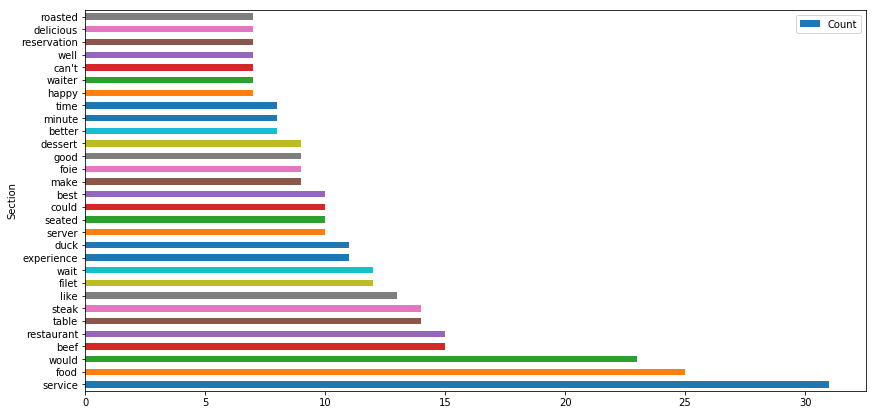

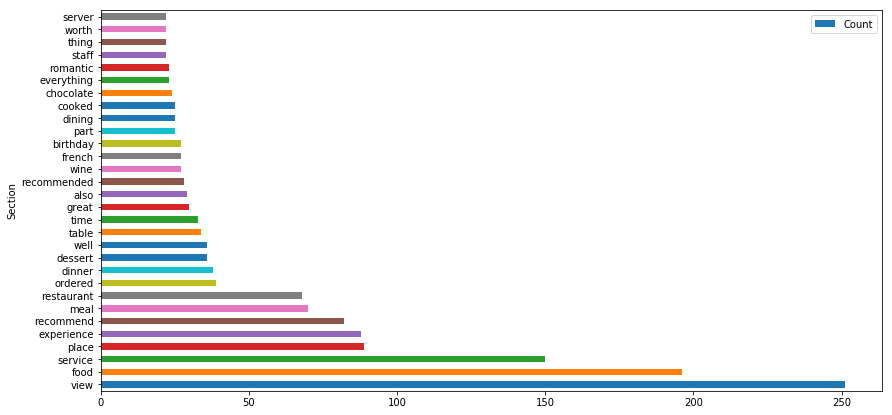

In [292]:
df_neg.plot("Section", "Count", kind="barh", figsize=(14,7), legend=True)
df_pos.plot("Section", "Count", kind="barh", figsize=(14,7))